In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

C:\Users\84132\anaconda3\envs\mfe-preprogram\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
def return_ohlc(df):
    c = df.close
    cc = c/c.shift(1)-1
    return cc

In [3]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [4]:
def max_drawdown(df):
    c = df.close
    cv = np.array(c)
    cv = maxProfit(cv)
    return cv
def maxProfit(prices):
    n = len(prices)
    max_price = prices[0]
    prices[0] = 0
    ans = 0
    for i in range(1,n):
        if prices[i]>max_price:
            max_price = prices[i]
        ans = min(ans,prices[i]-max_price)
        prices[i] = ans
    return prices

In [5]:
def series_plot(data, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

In [6]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///data/data.db'

In [7]:
# Parameters
from_date = "2021-11-29 00:00:00"
to_date = "2021-12-13 00:00:00"
token = "BTC"
connection_string = "sqlite:///data/data.db"


In [8]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [9]:
prices['return'] = return_ohlc(prices)
prices['volatility'] = vol_ohlc(prices)
prices['drawdown'] = max_drawdown(prices)
prices

,open,high,low,close,volume,volumeUSD,token,chain,return,volatility,drawdown
ts,,,,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC,NaN,NaN,0.00
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC,0.008588,NaN,0.00
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC,-0.002056,NaN,-118.85
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC,-0.005731,NaN,-449.49
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC,0.000853,NaN,-449.49
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-12 19:00:00,50274.37,50828.13,50274.37,50489.97,1629.235048,8.234571e+07,BTC,BTC,0.004102,0.097774,-12121.43
2021-12-12 20:00:00,50481.75,50621.33,50148.04,50240.20,424.455328,2.138626e+07,BTC,BTC,-0.004947,0.097824,-12121.43
2021-12-12 21:00:00,50245.59,50589.46,50180.32,50305.85,410.233785,2.068859e+07,BTC,BTC,0.001307,0.099950,-12121.43


In [10]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

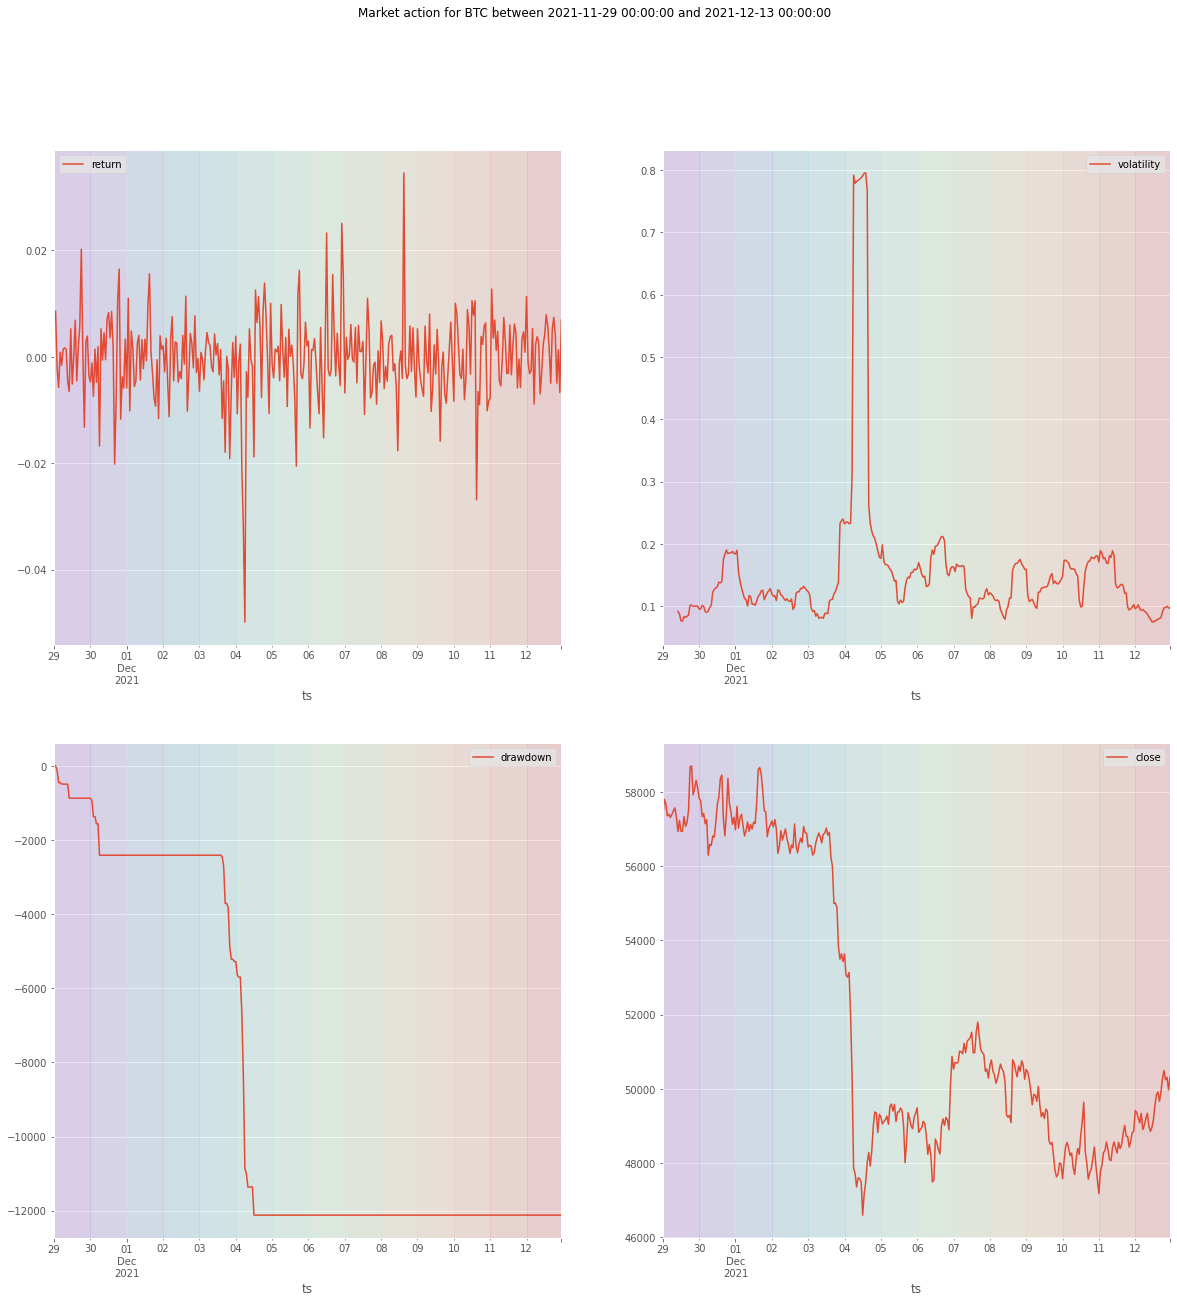

In [11]:
series_plot(prices[['return']], ax=ax[0, 0])
series_plot(prices[['volatility']], ax=ax[0, 1])
series_plot(prices[['drawdown']], ax=ax[1, 0])
series_plot(prices[['close']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

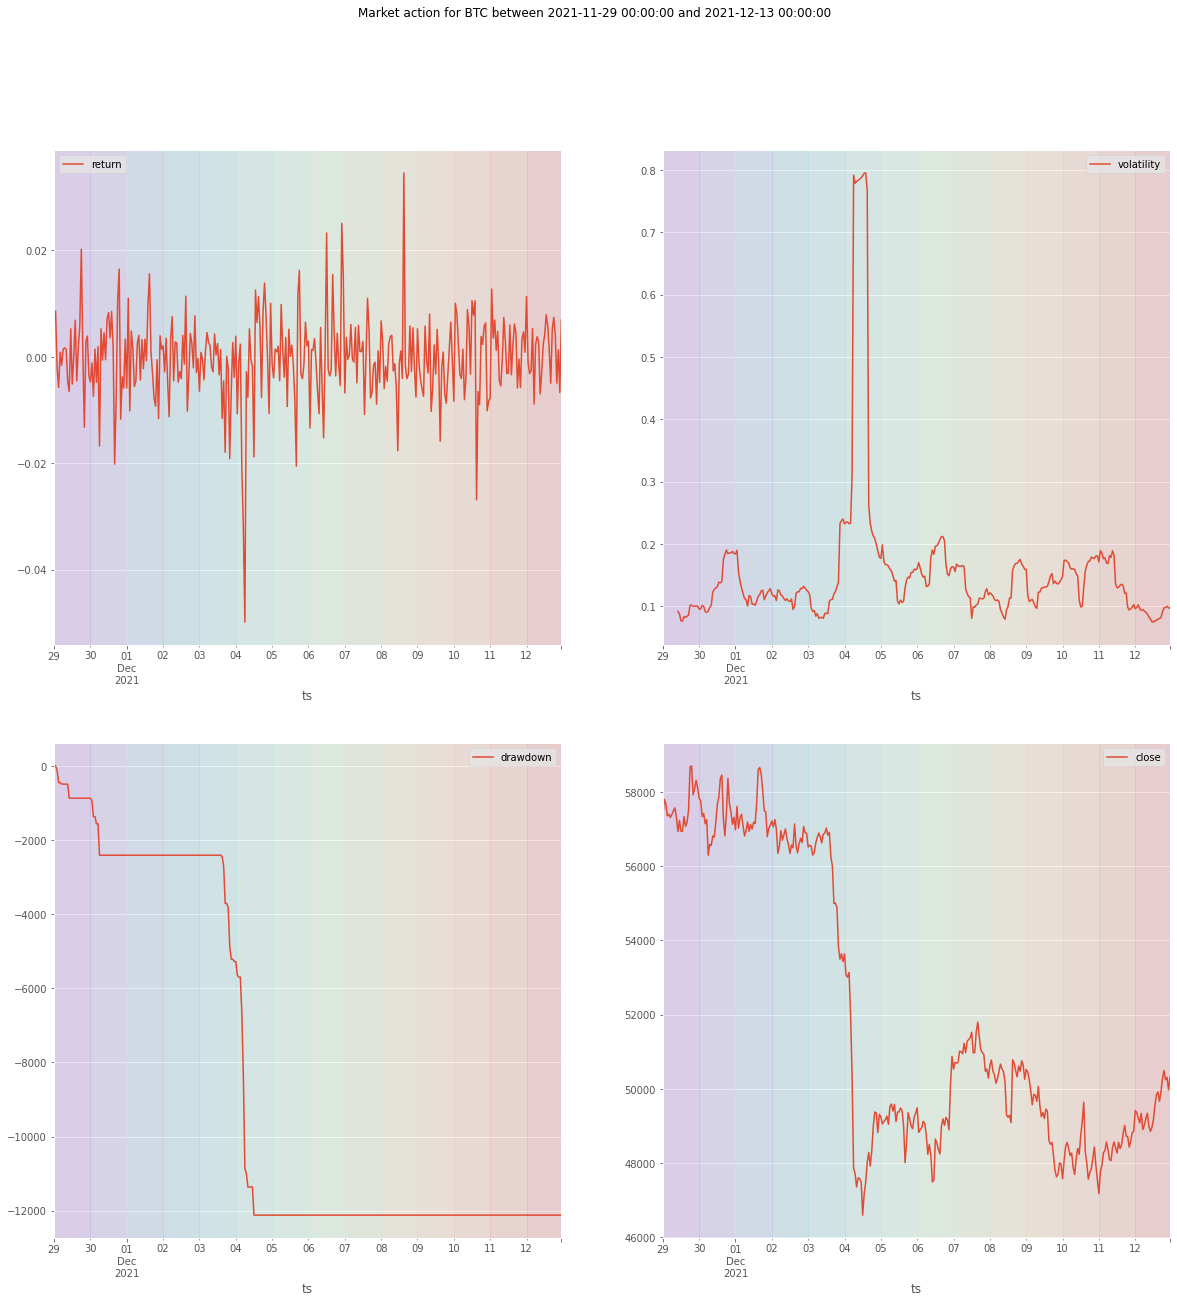

In [12]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)